In [1]:
from IPython.core.debugger import set_trace

In [2]:
import numpy as np
from numpy.random import seed
seed(1)
#display all values from array
np.set_printoptions(threshold=np.nan)
#display not in scientific format
np.set_printoptions(suppress=True)

from tensorflow import set_random_seed
set_random_seed(2)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
DATA_FREQUENCY = 500
SAMPLING_RATE = 5
FREQUENCY_TO_SAMPLING_RATIO = DATA_FREQUENCY // SAMPLING_RATE

In [4]:
import random


def create_chunks_with_seizures(patient_data, seizure_seconds, chunk_size):
    number_of_chunks = len(seizure_seconds)
    #     16 when without time
    chunks_input = np.zeros((number_of_chunks, chunk_size, 17))
    chunks_target = np.zeros(number_of_chunks)

    for seizure_number in range(0, number_of_chunks):
        (seizure_time, seizure_index) = seizure_seconds[seizure_number]
        chunk_start_index = seizure_index
        chunk_end_index = chunk_start_index + chunk_size
        chunks_input[seizure_number] = patient_data[chunk_start_index:chunk_end_index, :]
        # seizure
        chunks_target[seizure_number] = 1

    return (chunks_input, chunks_target)


def is_in_seizure_range(index, seizure_seconds, chunk_size):
    for (seizure_time, seizure_index) in seizure_seconds:
        seizure_start_index = seizure_index
        seizure_end_index = seizure_start_index + chunk_size
        if index in range(seizure_start_index, seizure_end_index):
            return True

    return False


def create_non_seizure_data_start_index(data_size, chunk_size, seizure_seconds):
    start_index = random.randint(0, data_size - chunk_size)

    while (is_in_seizure_range(start_index, seizure_seconds, chunk_size)):
        start_index = random.randint(0, data_size - chunk_size)

    return start_index


def create_chunks_without_seizures(patient_data, seizure_seconds, chunk_size):
    number_of_chunks = len(seizure_seconds)
    #     16 when without time
    chunks_input = np.zeros((number_of_chunks, chunk_size, 17))
    chunks_target = np.zeros(number_of_chunks)
    (data_size, channels) = patient_data.shape

    for chunk_number in range(0, number_of_chunks):
        chunk_start_index = create_non_seizure_data_start_index(data_size, chunk_size, seizure_seconds)

        chunk_end_index = chunk_start_index + chunk_size
        chunks_input[chunk_number] = patient_data[chunk_start_index:chunk_end_index, :]
        # non-seizure
        chunks_target[chunk_number] = 0

    return (chunks_input, chunks_target)


def flatten_chunks(chunks_input, chunks_target):
    train_input = []
    train_target = []

    for patient_number in range(0, len(chunks_input)):
        patient_data = chunks_input[patient_number]
        patient_targets = chunks_target[patient_number]
        for chunk_number in range(0, len(patient_data)):
            train_input.append(patient_data[chunk_number])
            train_target.append(patient_targets[chunk_number])

    train_input = np.array(train_input)
    train_target = np.array(train_target)

    #remove time column
    train_input = train_input[:, :, :-1]
    
    return train_input, train_target 


def prepare_chunks(input, target, chunk_size):
    chunks_input = []
    chunks_target = []

    for patient_number in range(0, len(input)):
        patient_chunks_input = []
        patient_chunks_target = []
        seizure_seconds = target[patient_number]
        patient_data = input[patient_number]
        (seizure_chunks_input, seizure_chunks_target) = create_chunks_with_seizures(patient_data,
                                                                                    seizure_seconds,
                                                                                    chunk_size)
        patient_chunks_input.extend(seizure_chunks_input)
        patient_chunks_target.extend(seizure_chunks_target)

        (non_seizure_chunks_input, non_seizure_chunks_target) = create_chunks_without_seizures(patient_data,
                                                                                               seizure_seconds,
                                                                                               chunk_size)
        patient_chunks_input.extend(non_seizure_chunks_input)
        patient_chunks_target.extend(non_seizure_chunks_target)

        chunks_input.append(np.array(patient_chunks_input))
        chunks_target.append(np.array(patient_chunks_target))

    return np.array(chunks_input), np.array(chunks_target)

In [7]:
from data_reader import read_data

(input, target, headers) = read_data(data_path='data', 
                                     sampling_rate=SAMPLING_RATE, 
                                     data_frequency=DATA_FREQUENCY)

Loaded input file: 1
Loaded input file: 2
Loaded input file: 3
Loaded input file: 4
Loaded input file: 5
Loaded input file: 6
Loaded input file: 7
Loaded input file: 8
Loaded input file: 9
Loaded input file: 10
Loaded input file: 11
Loaded input file: 12
Loaded input file: 13
Loaded input file: 14
Loaded input file: 15
Loaded input file: 16
Loaded input file: 17
Loaded input file: 18
Loaded input file: 19
Loaded input file: 20
Loaded input file: 21
Loaded input file: 22
Loaded input file: 23
Loaded input file: 24
Loaded input file: 25
Loaded input file: 26
Loaded input file: 27
Loaded input file: 28
Loaded input file: 29
Loaded input file: 30
Loaded input file: 31
Loaded input file: 32
Loaded input file: 33
Loaded input file: 34
Loaded input file: 35
Loaded input file: 36
Loaded input file: 37
Loaded input file: 38
Loaded input file: 39
Loaded input file: 40
Loaded input file: 41
Loaded input file: 42
Loaded input file: 43
Loaded input file: 44
Loaded input file: 45
Loaded input file: 

In [21]:
#data without normalization
(chunks_input, chunks_target) = prepare_chunks(input, target, chunk_size=4*100)
(x, y) = flatten_chunks(chunks_input, chunks_target)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

#normalize data
scalers = {}
for channel_number in range(x.shape[1]):
    scalers[channel_number] = StandardScaler()
    x[:, channel_number, :] = scalers[channel_number].fit_transform(x[:, channel_number, :]) 
    
    
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

In [22]:
#callbacks
from keras import callbacks

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='acc', 
        patience=4
    ),
#     callbacks.ModelCheckpoint(
#         filepath='best_model.h5', 
#         monitor='val_loss', 
#         save_best_only=True
#     ),
#     callbacks.TensorBoard(
#         log_dir='logs',
#         histogram_freq=1
#     )
]

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(400, 16)))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks_list,
                    shuffle=False
#                     validation_split=0.05
                   )

score = model.evaluate(x_test, y_test, batch_size=64)
print("Accuracy: %.2f%%" % (score[1]*100))

Train on 1058 samples, validate on 118 samples
Epoch 1/100
1058/1058 [==============================] - 0s 430us/step - loss: 0.9243 - acc: 0.5369 - val_loss: 0.7595 - val_acc: 0.5424
Epoch 2/100
1058/1058 [==============================] - 0s 166us/step - loss: 0.3213 - acc: 0.8932 - val_loss: 0.8762 - val_acc: 0.5763
Epoch 3/100
1058/1058 [==============================] - 0s 168us/step - loss: 0.0964 - acc: 0.9811 - val_loss: 0.9351 - val_acc: 0.5847
Epoch 4/100
1058/1058 [==============================] - 0s 159us/step - loss: 0.0277 - acc: 0.9981 - val_loss: 1.0601 - val_acc: 0.6017
Epoch 5/100
1058/1058 [==============================] - 0s 159us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 1.2466 - val_acc: 0.6186
Epoch 6/100
1058/1058 [==============================] - 0s 170us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.4297 - val_acc: 0.6271
Epoch 7/100
1058/1058 [==============================] - 0s 160us/step - loss: 3.6803e-04 - acc: 1.0000 - val_loss: 1.5968 - val_ac

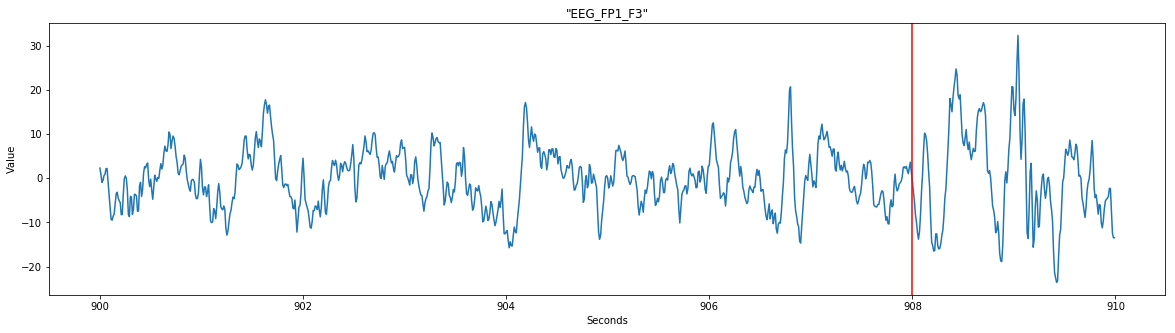

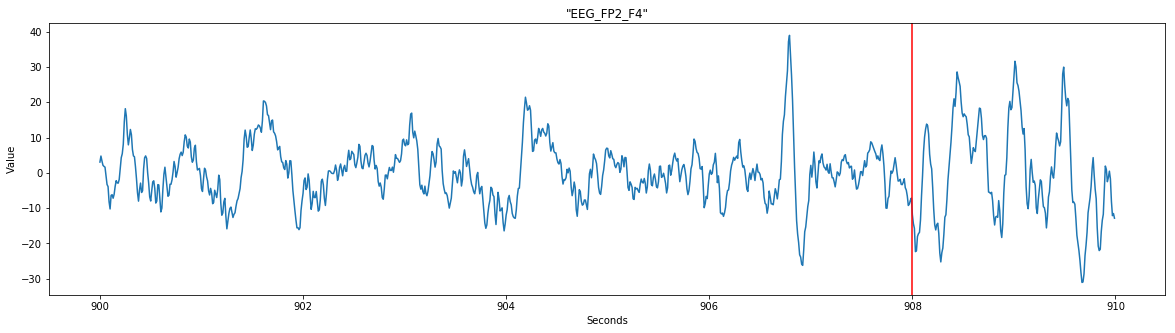

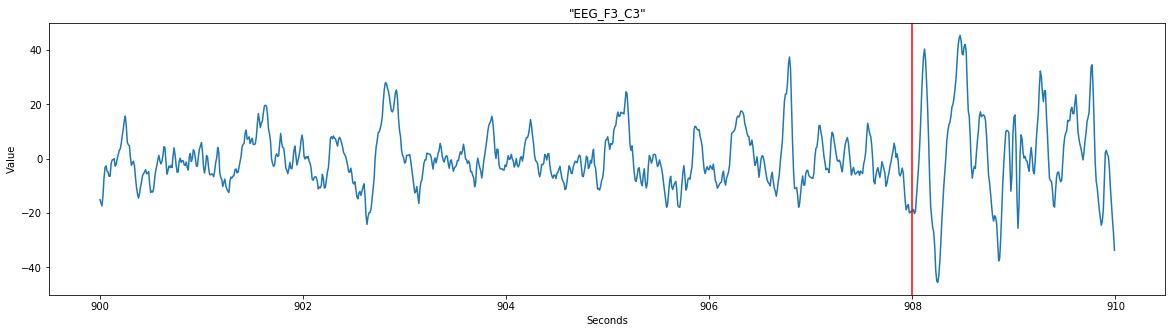

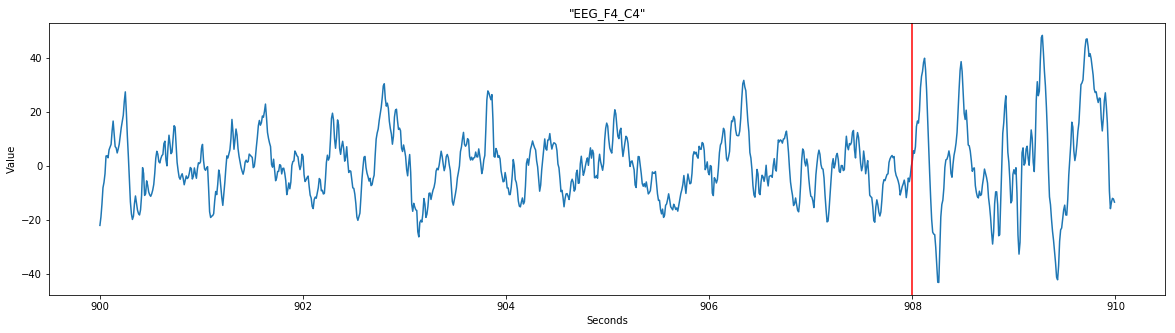

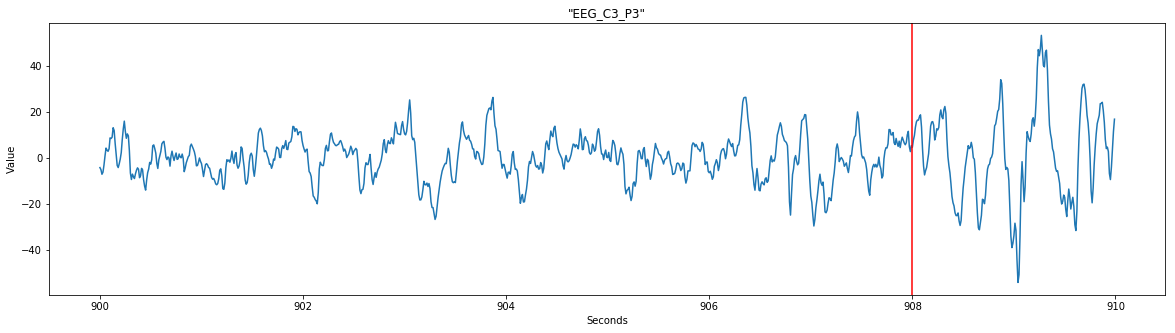

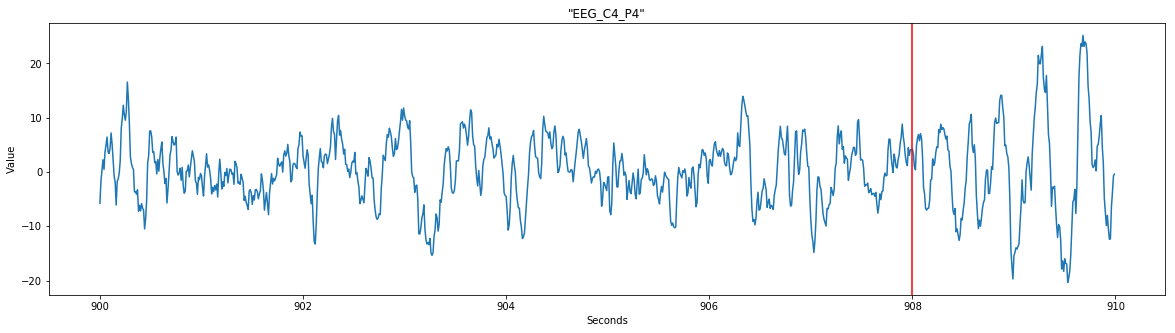

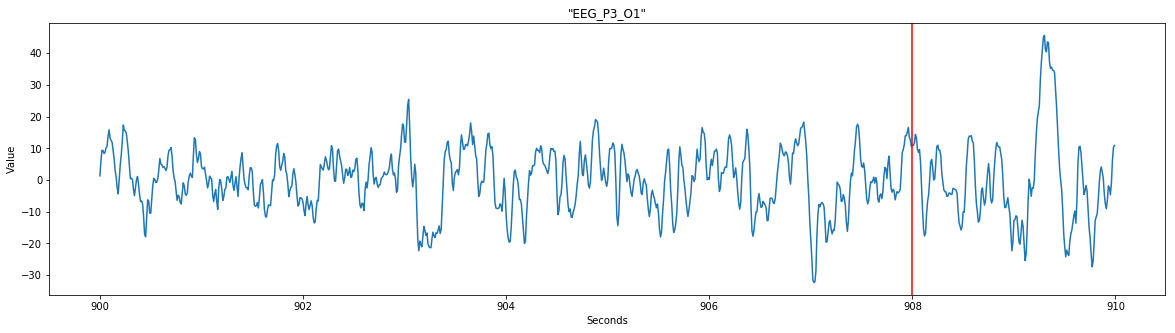

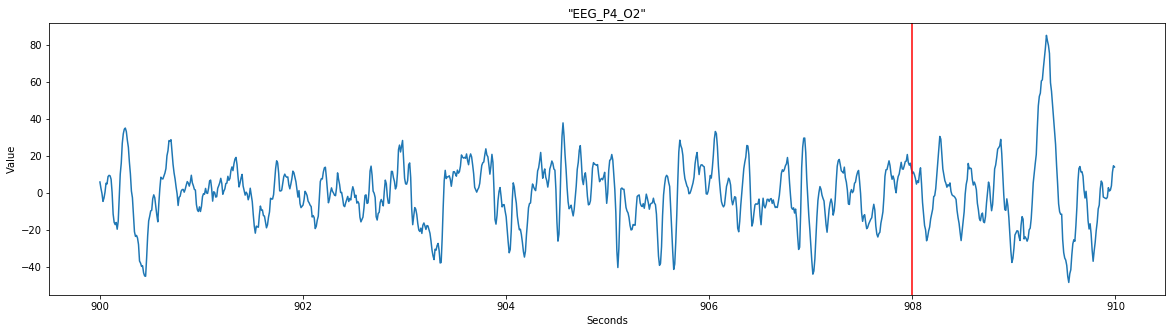

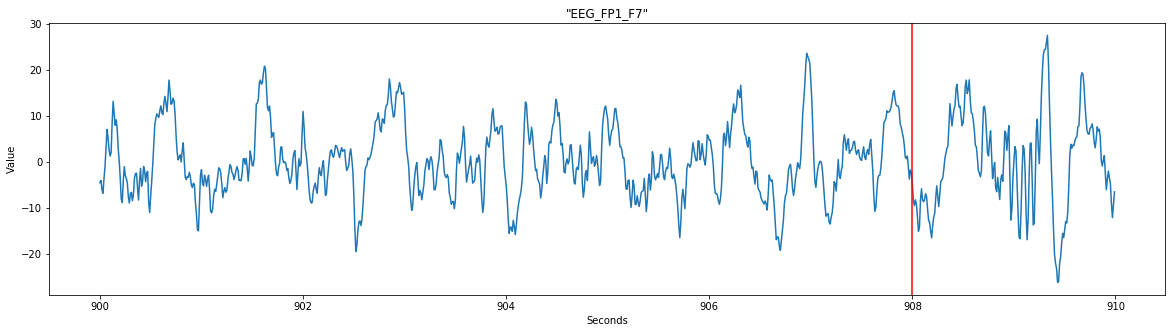

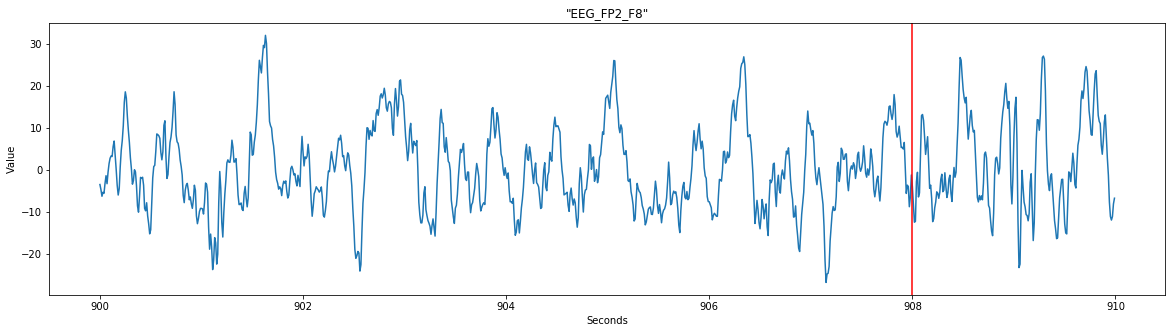

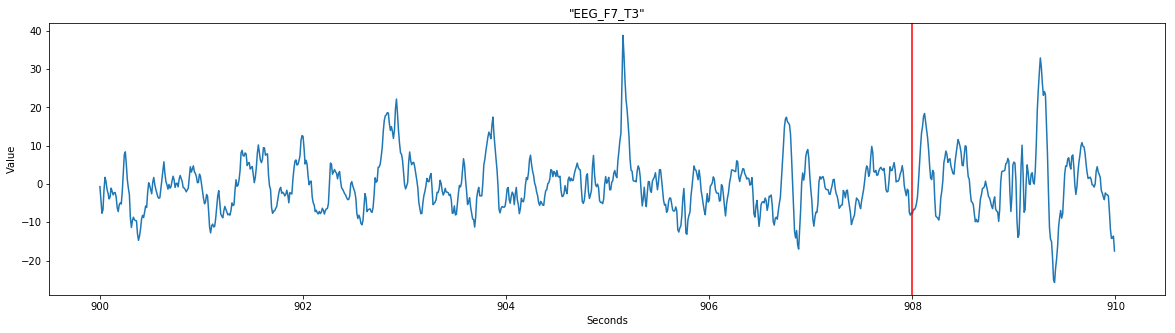

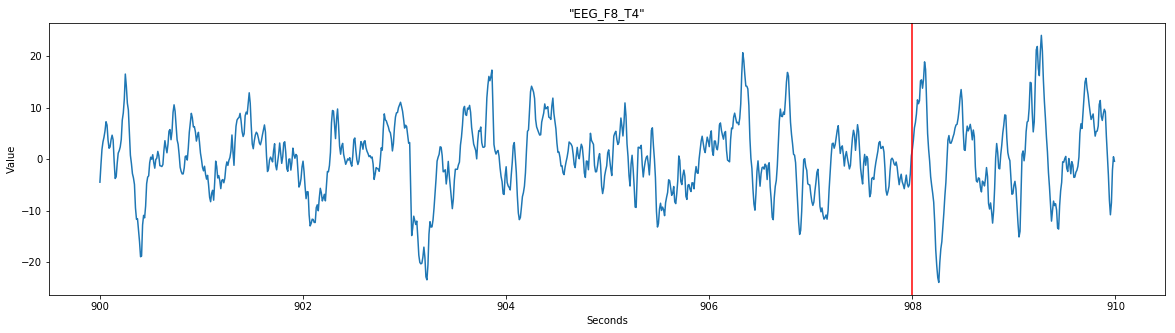

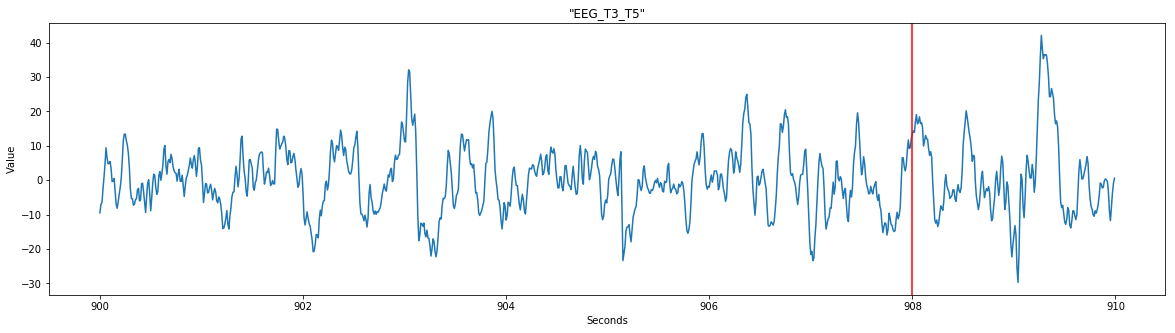

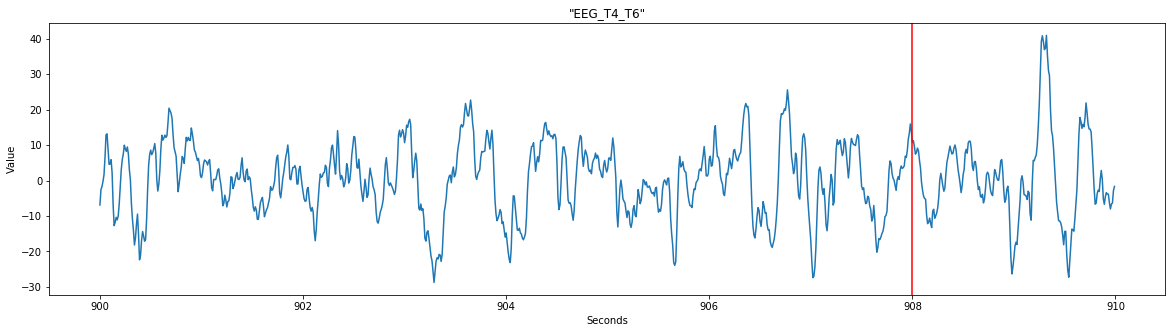

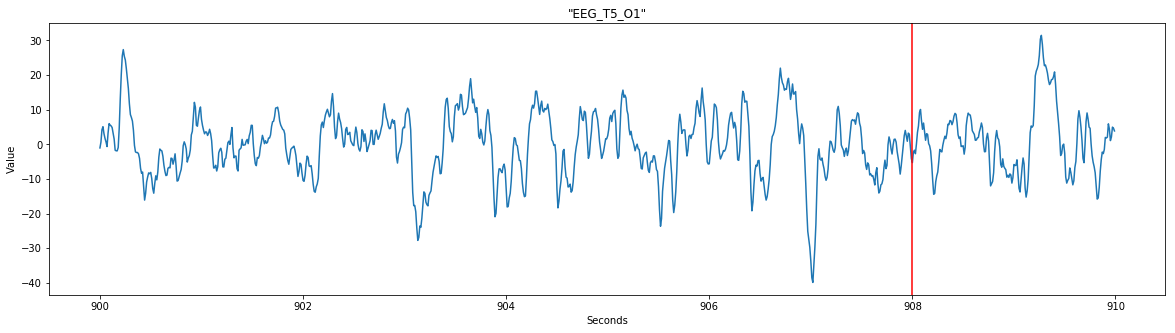

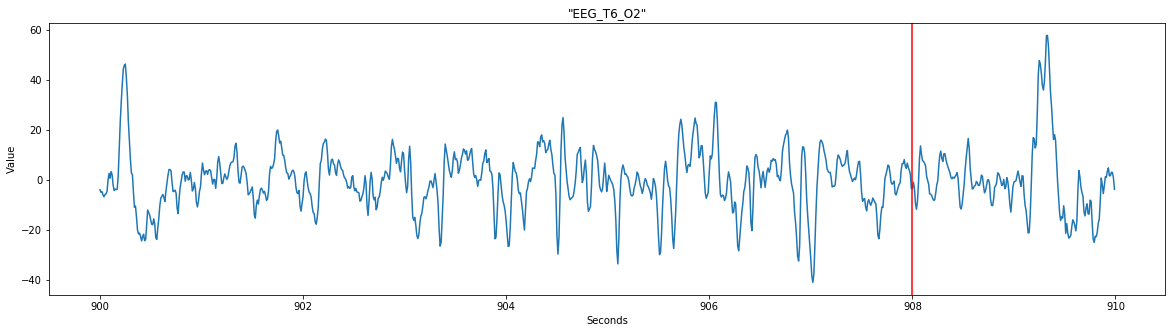

In [24]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]


def draw_plots(input, target, headers, patient, end_second, start_second=0):
    patient_columns = input[patient]
    targets = target[patient]
    time_column = patient_columns[:, -1]
    channel_columns = patient_columns[:, :-1]
    (rows, columns) = channel_columns.shape
    
    for column in range(columns):
        channel = channel_columns[:, column]
        plt.figure(column)
        plt.xlabel('Seconds')
        plt.ylabel('Value')
        plt.title(headers[column])
        start = start_second * FREQUENCY_TO_SAMPLING_RATIO
        end = end_second * FREQUENCY_TO_SAMPLING_RATIO
        plt.plot(time_column[start:end], channel[start:end])
        draw_targets_in_range(targets, start_second, end_second)
     
    
def draw_targets_in_range(targets, start_second, end_second):
    for (target, target_index) in targets:
        if (target >= start_second) and (target <= end_second):
            plt.axvline(x=target, color='r')
            
            
draw_plots(input, target, headers, patient=0, start_second=900, end_second=910)

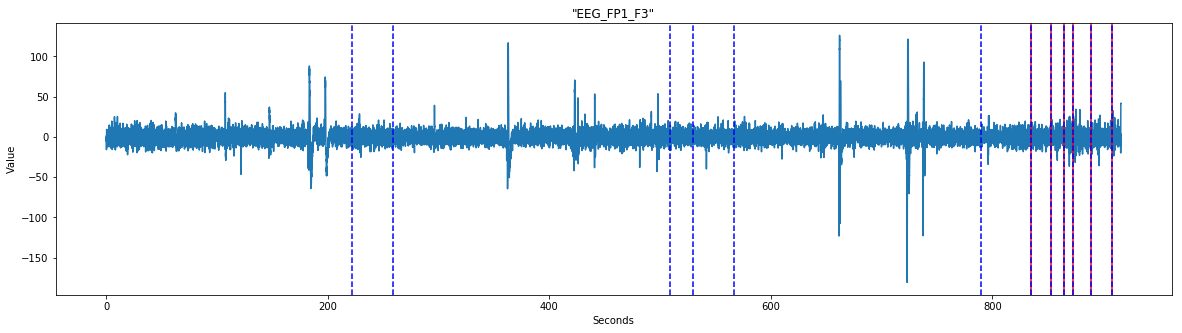

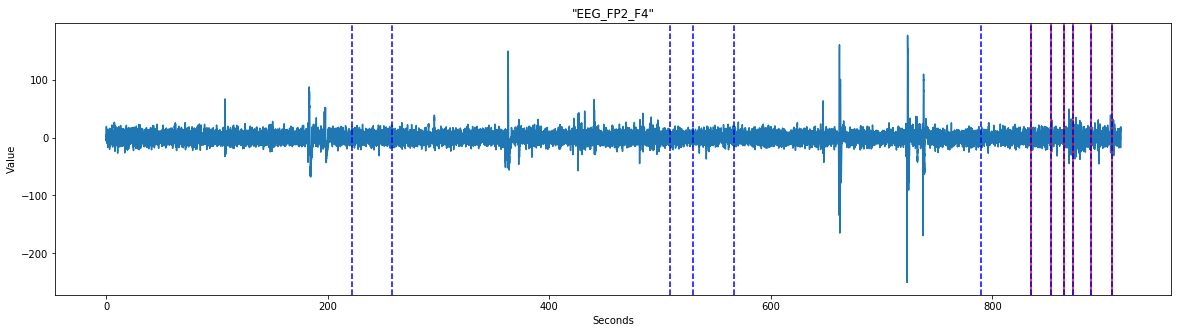

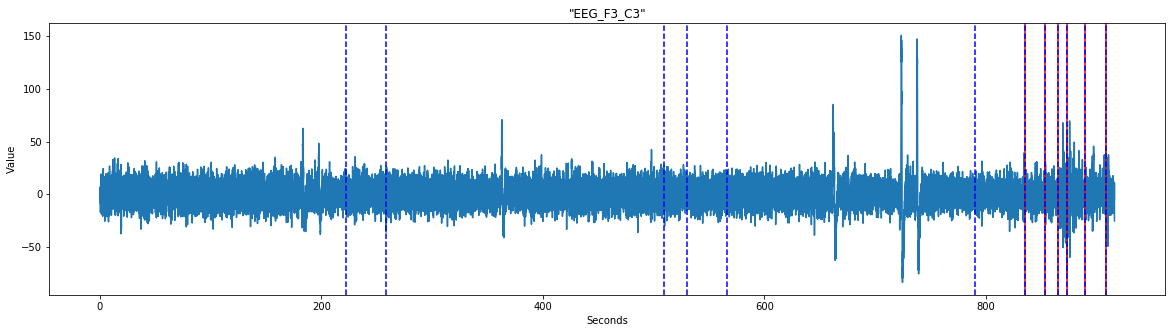

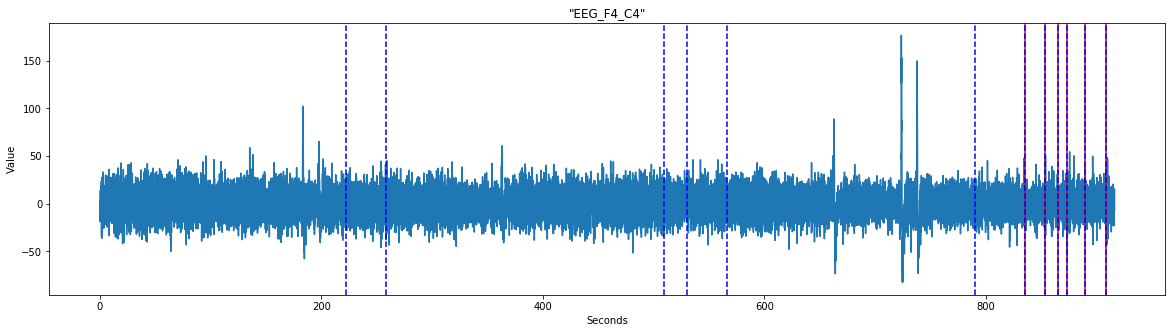

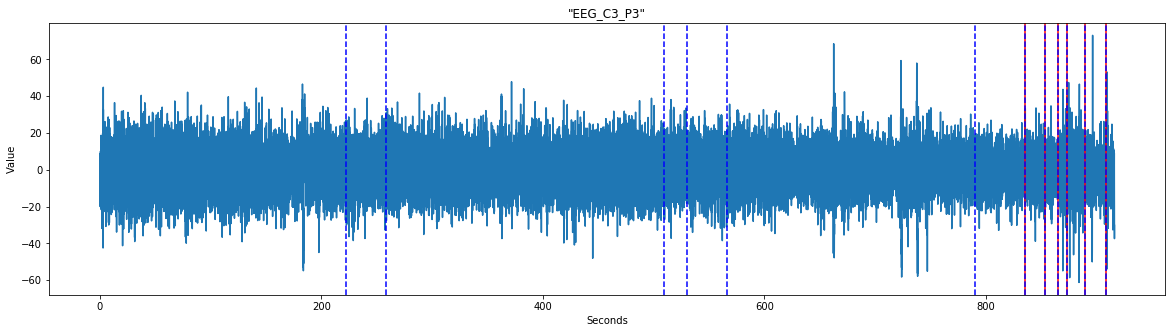

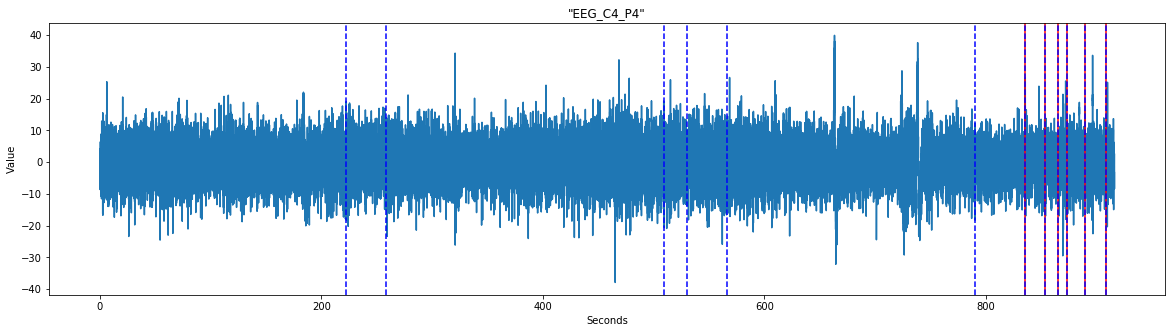

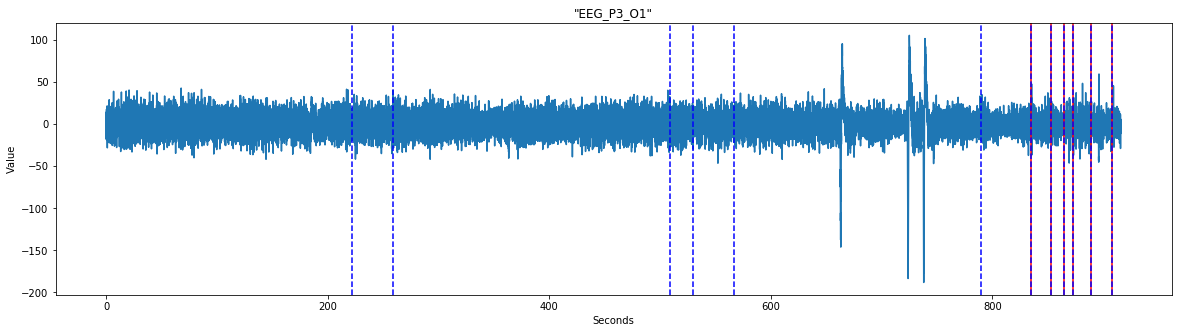

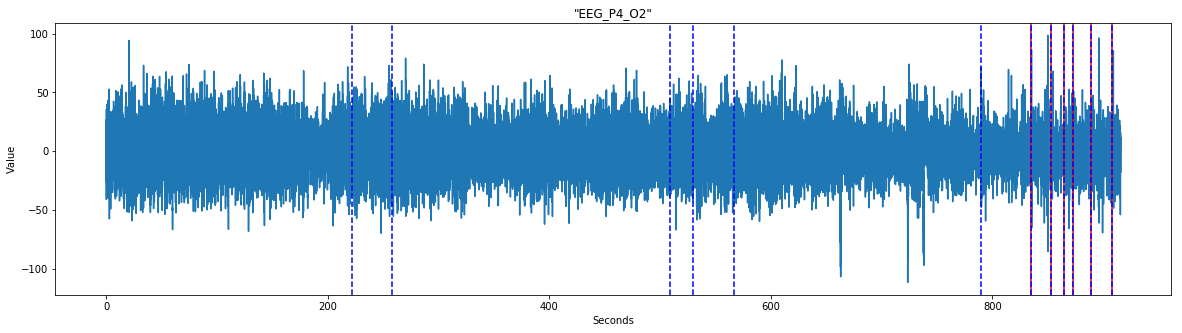

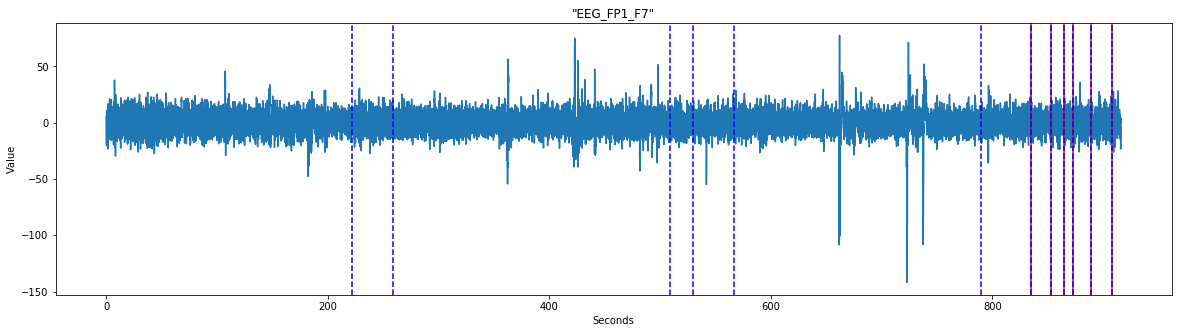

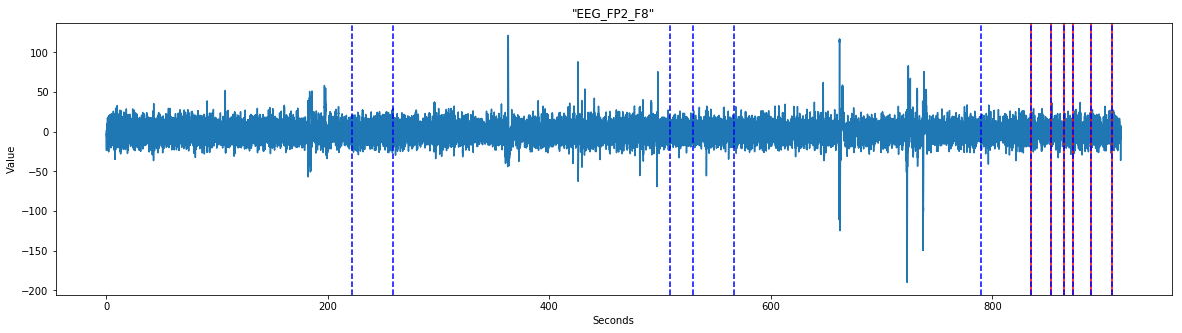

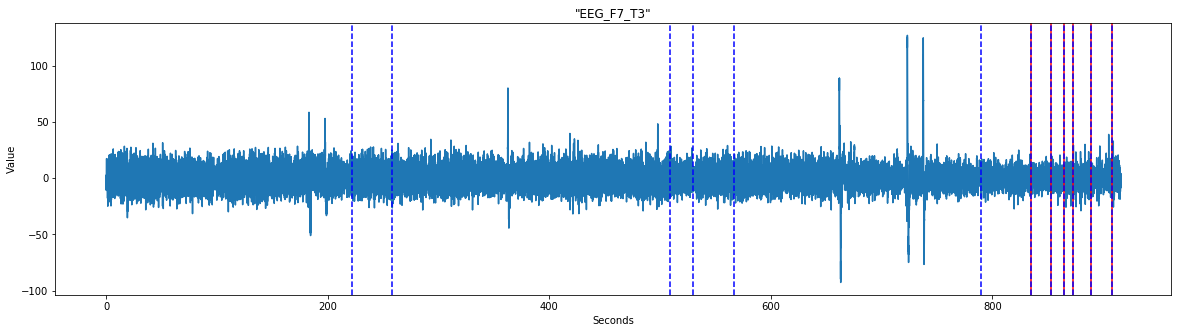

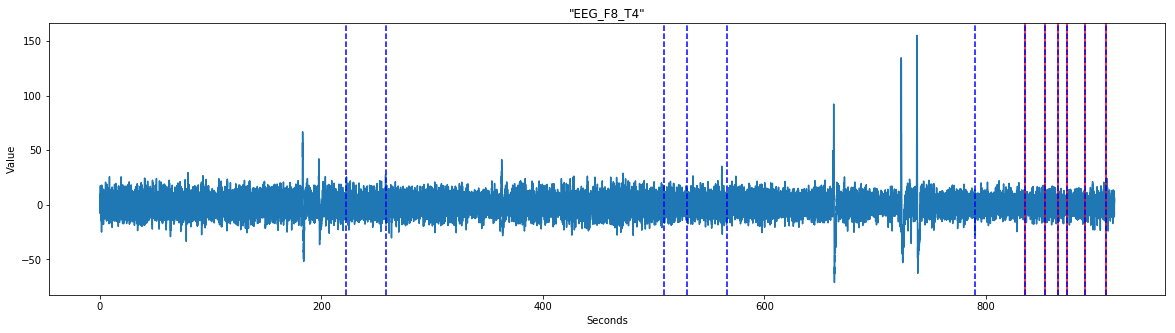

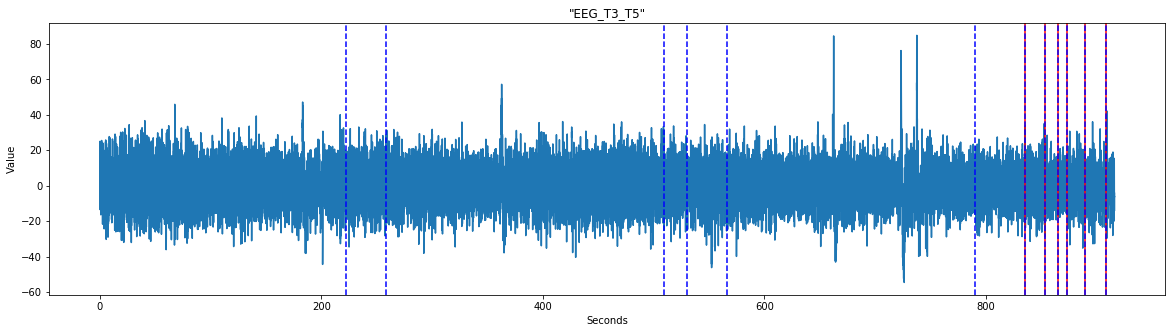

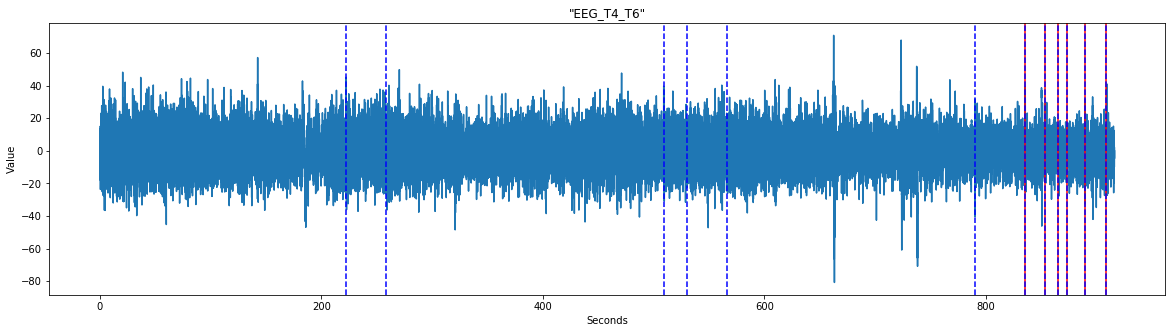

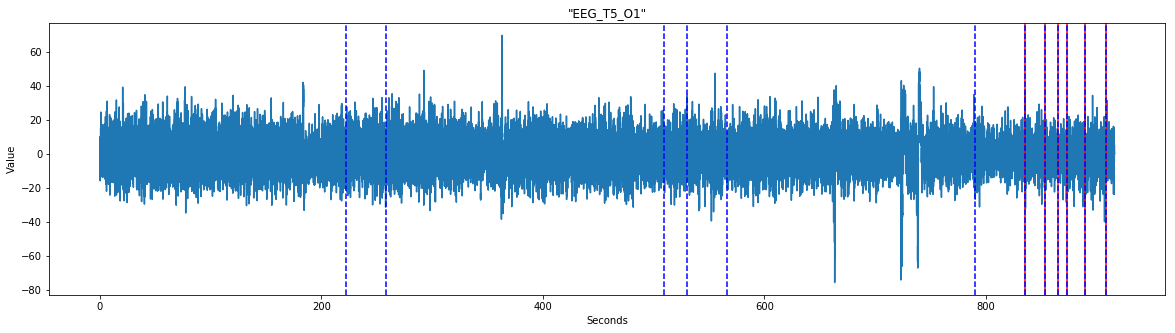

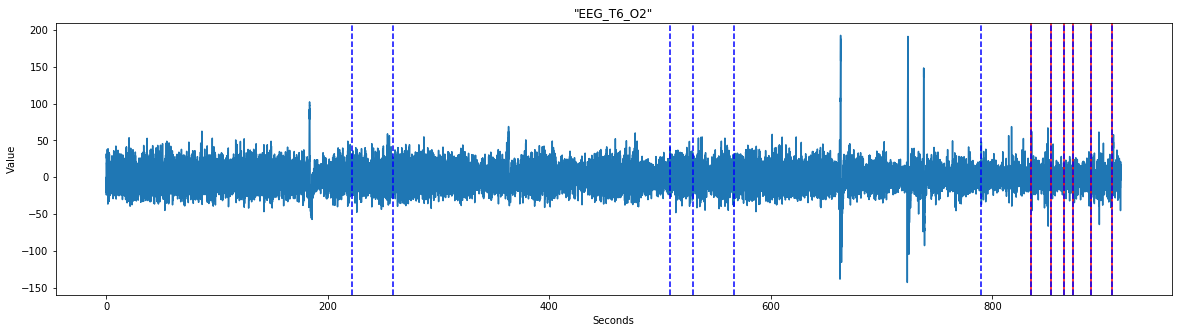

In [25]:
#draw chosen chunks
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]


def draw_plots_with_chunks(input, target, headers, patient, chunks_input, to_pdf=False):
    patient_columns = input[patient]
    targets = target[patient]
    time_column = patient_columns[:, -1]
    channel_columns = patient_columns[:, :-1]
    (rows, columns) = channel_columns.shape
    chunks_input = chunks_input[patient]
    
    for column in range(columns):
        channel = channel_columns[:, column]
        plt.figure(column)
        plt.xlabel('Seconds')
        plt.ylabel('Value')
        plt.title(headers[column])
        plt.plot(time_column, channel)
        draw_targets(targets)
        draw_chunks_start(chunks_input)
        if to_pdf:
            plt.savefig("chanel-{}.pdf".format(column), bbox_inches='tight')
      
    
def draw_targets(targets):
    for (target, target_index) in targets:
        plt.axvline(x=target, color='r')

        
def draw_chunks_start(chunks_input):
    for chunk_number in range(0, len(chunks_input)):
        chunk = chunks_input[chunk_number]
        
        plt.axvline(x=chunk[0, -1], color='b', linestyle="--")
        
        
draw_plots_with_chunks(input, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)